<a href="https://colab.research.google.com/github/hilars/deep-learning/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [ ]:
from google.colab import drive

In [ ]:

# Setting Training Hyperparameters
batch_size = 32  # original ResNet paper uses batch_size = 128 for training
epochs = 200
data_augmentation = True
num_classes = 10
  
# Data Preprocessing 
subtract_pixel_mean = True
n = 3
  
# Select ResNet Version
version = 1
  
# Computed depth of 
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
  
# Model name, depth and version
model_type = 'ResNet % dv % d' % (depth, version)
  
# Load the CIFAR-10 data.
(x_train1, y_train), (x_test, y_test) = cifar10.load_data()
  
# Input image dimensions.
input_shape = x_train1.shape[1:]
  
# Normalize data.
x_train = x_train1.astype('float32') / 255
x_test = x_test.astype('float32') / 255
  
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis = 0)
    x_train -= x_train_mean
    x_test -= x_train_mean
  
# Print Training and Test Samples 
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
  
# Convert class vectors to binary class matrices.
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
import cv2 as cv
from matplotlib import pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


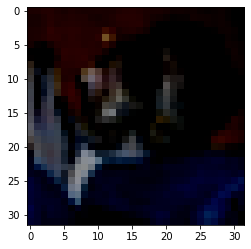

In [ ]:
plt.imshow(x_test[0])

In [ ]:
# Setting LR for different number of Epochs
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
# Basic ResNet Building Block
def resnet_layer(inputs,
                 num_filters = 16,
                 kernel_size = 3,
                 strides = 1,
                 activation ='relu',
                 batch_normalization = True,):
    conv = Conv2D(num_filters,
                  kernel_size = kernel_size,
                  strides = strides,
                  padding ='same',
                  kernel_initializer ='he_normal',
                  kernel_regularizer = l2(1e-4))
  
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
#
def resnet_v1(input_shape, depth, num_classes = 10):
	
	if (depth - 2) % 6 != 0:
		raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])')
	# Start model definition.
	num_filters = 16
	num_res_blocks = int((depth - 2) / 6)

	inputs = Input(shape = input_shape)
	x = resnet_layer(inputs = inputs)
	# Instantiate the stack of residual units
	for stack in range(3):
		for res_block in range(num_res_blocks):
			strides = 1
			if stack > 0 and res_block == 0: # first layer but not first stack
				strides = 2 # downsample
			y = resnet_layer(inputs = x,
							num_filters = num_filters,
							strides = strides)
			y = resnet_layer(inputs = y,
							num_filters = num_filters,
							activation = None)
			if stack > 0 and res_block == 0: # first layer but not first stack
				# linear projection residual shortcut connection to match
				# changed dims
				x = resnet_layer(inputs = x,
								num_filters = num_filters,
								kernel_size = 1,
								strides = strides,
								activation = None,
								batch_normalization = False)
			x = keras.layers.add([x, y])
			x = Activation('relu')(x)
		num_filters *= 2

	# Add classifier on top.
	# v1 does not use BN after last shortcut connection-ReLU
	x = AveragePooling2D(pool_size = 8)(x)
	y = Flatten()(x)
	outputs = Dense(num_classes,
					activation ='softmax',
					kernel_initializer ='he_normal')(y)

	# Instantiate model.
	model = Model(inputs = inputs, outputs = outputs)
	return model


In [ ]:
# ResNet V2 architecture
def resnet_v2(input_shape, depth, num_classes = 10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n + 2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
  
    inputs = Input(shape = input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs = inputs,
                     num_filters = num_filters_in,
                     conv_first = True)
  
    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample
  
            # bottleneck residual unit
            y = resnet_layer(inputs = x,
                             num_filters = num_filters_in,
                             kernel_size = 1,
                             strides = strides,
                             activation = activation,
                             batch_normalization = batch_normalization,
                             conv_first = False)
            y = resnet_layer(inputs = y,
                             num_filters = num_filters_in,
                             conv_first = False)
            y = resnet_layer(inputs = y,
                             num_filters = num_filters_out,
                             kernel_size = 1,
                             conv_first = False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs = x,
                                 num_filters = num_filters_out,
                                 kernel_size = 1,
                                 strides = strides,
                                 activation = None,
                                 batch_normalization = False)
            x = keras.layers.add([x, y])
  
        num_filters_in = num_filters_out
  
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size = 8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation ='softmax',
                    kernel_initializer ='he_normal')(y)
  
    # Instantiate model.
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
# Main function 
if version == 2:
    model = resnet_v2(input_shape = input_shape, depth = depth)
else:
    model = resnet_v1(input_shape = input_shape, depth = depth)
  
model.compile(loss ='categorical_crossentropy',
              optimizer = Adam(learning_rate = lr_schedule(0)),
              metrics =['accuracy'])
model.summary()
print(model_type)
  
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_% s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
  
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor ='val_acc',
                             verbose = 1,
                             save_best_only = True)
  
lr_scheduler = LearningRateScheduler(lr_schedule)
  
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                               cooldown = 0,
                               patience = 5,
                               min_lr = 0.5e-6)
  
callbacks = [checkpoint, lr_reducer, lr_scheduler]
  
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size = batch_size,
              epochs = epochs,
              validation_data =(x_test, y_test),
              shuffle = True,
              callbacks = callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center = False,
        # set each sample mean to 0
        samplewise_center = False,
        # divide inputs by std of dataset
        featurewise_std_normalization = False,
        # divide each input by its std
        samplewise_std_normalization = False,
        # apply ZCA whitening
        zca_whitening = False,
        # epsilon for ZCA whitening
        zca_epsilon = 1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range = 0,
        # randomly shift images horizontally
        width_shift_range = 0.1,
        # randomly shift images vertically
        height_shift_range = 0.1,
        # set range for random shear
        shear_range = 0.,
        # set range for random zoom
        zoom_range = 0.,
        # set range for random channel shifts
        channel_shift_range = 0.,
        # set mode for filling points outside the input boundaries
        fill_mode ='nearest',
        # value used for fill_mode = "constant"
        cval = 0.,
        # randomly flip images
        horizontal_flip = True,
        # randomly flip images
        vertical_flip = False,
        # set rescaling factor (applied before any other transformation)
        rescale = None,
        # set function that will be applied on each input
        preprocessing_function = None,
        # image data format, either "channels_first" or "channels_last"
        data_format = None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split = 0.0)
  
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
  
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                        validation_data =(x_test, y_test),
                        epochs = epochs, verbose = 1, workers = 4,
                        callbacks = callbacks)
  
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

NameError: ignored